In [ ]:
# Chatbot with LangGraph

!pip install packaging
!pip install dotenv
!pip install -U langgraph
!pip install -U langchain
!pip install langchain_ollama
!pip install langchain_community


   -------------------- ------------------- 1/2 [langchain_ollama]
   ---------------------------------------- 2/2 [langchain_ollama]



In [6]:
from dotenv import load_dotenv
import os

load_dotenv('../.env')

True

In [ ]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_ollama import ChatOllama

llm = ChatOllama(model="gemma3:4b", base_url="http://localhost:11434")

llm.invoke("Hello")

AIMessage(content='Hello there! How can I help you today? 😊 \n\nDo you want to:\n\n*   Chat about something?\n*   Ask me a question?\n*   Play a game?\n*   Get some information?\n\nJust let me know what you have in mind!', additional_kwargs={}, response_metadata={'model': 'gemma3:4b', 'created_at': '2025-05-03T04:21:18.5674311Z', 'done': True, 'done_reason': 'stop', 'total_duration': 7322275700, 'load_duration': 5866326600, 'prompt_eval_count': 10, 'prompt_eval_duration': 443036400, 'eval_count': 59, 'eval_duration': 1003156000, 'model_name': 'gemma3:4b'}, id='run--37eaefa0-452d-4b5d-abdd-b03d3186915b-0', usage_metadata={'input_tokens': 10, 'output_tokens': 59, 'total_tokens': 69})

In [12]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

def chatbot(state: State):
    response = llm.invoke(state["messages"])
    return {"messages":[response]}

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

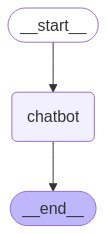

In [ ]:
from IPython.display import display, Image

# 랭그래프 구성 이미지화
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
graph.invoke({"messages": ["Hello", "my name is 성종"]})

{'messages': [HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='df8d2df4-f8dd-4a85-a4ff-f2f1f9bb2933'),
  HumanMessage(content='my name is 성종', additional_kwargs={}, response_metadata={}, id='fe719754-fffa-423d-b97b-bb4515f88d7e'),
  AIMessage(content='안녕하세요, 성종 씨! 만나서 반갑습니다. (Annyeonghaseyo, Seongjong ssi! Mannaseo bangapseumnida.)\n\nThat means "Hello, Seongjong! Nice to meet you."\n\nHow are you doing today? Is there anything you\'d like to chat about? 😊', additional_kwargs={}, response_metadata={'model': 'gemma3:4b', 'created_at': '2025-05-03T04:27:27.7716246Z', 'done': True, 'done_reason': 'stop', 'total_duration': 5526591600, 'load_duration': 4028722000, 'prompt_eval_count': 16, 'prompt_eval_duration': 335542600, 'eval_count': 64, 'eval_duration': 1112305900, 'model_name': 'gemma3:4b'}, id='run--a5aad489-df35-4b85-be81-e6ee3004238c-0', usage_metadata={'input_tokens': 16, 'output_tokens': 64, 'total_tokens': 80})]}

In [29]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool

@tool
def internet_search(query: str):
    """
    Search the web for realtime and latest information.
    for examples, news, stock market, weather updates etc.

    Args:
    query: The search query
    """
    search = TavilySearchResults(
        max_results=3,                      # 3개
        search_depth='advanced',
        include_answer=True,
        include_raw_content=True,
        preferred_sites=["news.google.com", "news.naver.com"]
    )

    response = search.invoke(query)
    return response

@tool
def llm_search(query: str):
    """
    Use the LLM model for general and basic information.
    """
    message = HumanMessage(query)
    response = llm.invoke(message)
    return response


# @tool : LLM이 사용할 수 있는 도구로 제공
internet_search("최신 주식 정보")

[{'title': '머니투데이 실시간 속보',
  'url': 'https://news.mt.co.kr/newsflash/newsflash.html',
  'content': '코스피\n2322.03 12.2\n코스닥\n654.49 3.96\n투자속보\n\nMTN[박진섭의 황금선] 대한항공과 협약…무인표적기 국산 부품화 추진 \'HJ중공업\'11:20\n\'주문 지연 오류\' 키움증권, 전 고객 국내 주식 수수료 1주일간 할인11:18\n디렉터스컴퍼니 "모든 콘텐츠에 AI기술 접목…새로운 광고회사될 것"11:05\n해성옵틱스 자회사, 美 전기차 제습제 공급 확대로 CAPA 증설11:04\n\n유라클 "스톡옵션 교부 외에 자사주 처분 계획없어"10:51\n\n\n투비소프트, 글로벌 테스트 자동화 기업과 전략적 파트너십 체결10:26\n\n미래에셋증권, 4월 개인투자용 국채 청약...5년물 연3.21% 금리10:24\n김병환 금융위원장 "종투사, 모험자본·기업금융 적극 공급해야"10:24\n셀루메드, ISO 13485 재인증 획득…글로벌 의료기기 생산체계 입증10:09\n\n더이앤엠, 미국 미디어 기업 해크먼 캐피털 파트너스 투자의향서 수령10:09 [...] 대한항공, 관세 여파로 화물수요 감소…목표가 14%↓-한투09:04\n[스팟]코스닥 4.61포인트(0.70%) 내린 653.84 출발09:02\n[스팟]코스피 4.24포인트(0.18%) 내린 2329.99 출발09:01\n\n[더벨]코스모화학, 새 먹거리 폐배터리 리사이클 사업 집중09:01\n\n\n"에이피알, 주가 급락으로 인한 실적 영향 없을 것"-다올08:58\n\n[더벨]한컴, 베트남 하노이 국립경제대학교에 AI 제품 공급08:58\n삼성전자, "관세타격 우려대비 양호 전망"…목표가 8만2000원-KB08:56\n카카오, 어닝쇼크 전망…카카오톡·콘텐츠 기대 어려워-하나증권08:53\n\n미국 관세로 불확실성↑…삼성전자 투심에도 부정적-유안타08:52\n\n\n한성크린텍 최대주주, 자사주 매입 "실

In [30]:
tools = [internet_search, llm_search]
tools

[StructuredTool(name='internet_search', description='Search the web for realtime and latest information.\nfor examples, news, stock market, weather updates etc.\n\nArgs:\nquery: The search query', args_schema=<class 'langchain_core.utils.pydantic.internet_search'>, func=<function internet_search at 0x000001B36F0862A0>),
 StructuredTool(name='llm_search', description='Use the LLM model for general and basic information.', args_schema=<class 'langchain_core.utils.pydantic.llm_search'>, func=<function llm_search at 0x000001B37F76BCE0>)]